[*********************100%%**********************]  1 of 1 completed
C:\Users\janak\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1572/1572 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 1119.2997
Linear Regression MSE: 9.249544659690642e-30
Decision Tree MSE: 282.0345264846596
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
LSTM Model MSE: 725.1582502191153


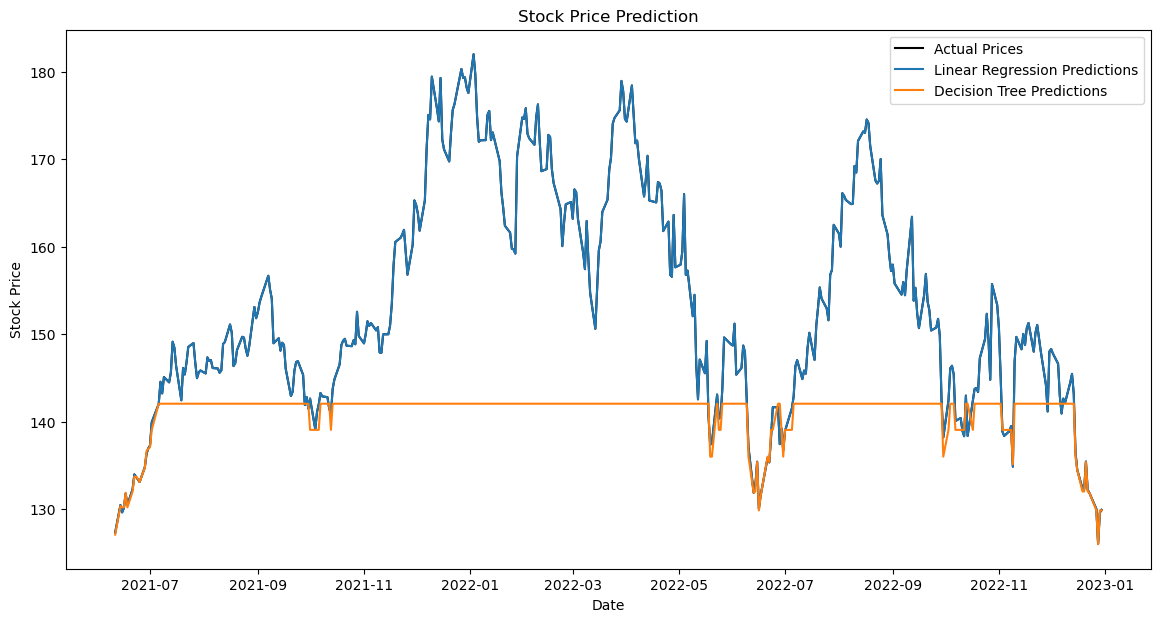

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Step 1: Data Collection
def fetch_stock_data(ticker, start, end):
    stock_data = yf.download(ticker, start=start, end=end)
    return stock_data

# Step 2: Data Preprocessing
def preprocess_data(data):
    # Handle missing values by forward fill
    data = data.ffill()
    return data

# Step 3: Feature Engineering
def feature_engineering(data):
    data['MA20'] = data['Close'].rolling(window=20).mean()
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
    data.dropna(inplace=True)
    return data

# Prepare data for training
def prepare_data_for_training(data):
    X = data[['Open', 'High', 'Low', 'Close', 'Volume', 'MA20', 'MA50', 'EMA20']]
    y = data['Close']
    return X, y

# Step 4: Model Selection and Training
def train_models(X_train, y_train):
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor()
    }
    
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model
    return trained_models

# Train LSTM Model
def train_lstm_model(X_train, y_train):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, batch_size=1, epochs=1)
    return model

# Step 5: Model Evaluation
def evaluate_models(models, X_test, y_test):
    for name, model in models.items():
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        print(f'{name} MSE: {mse}')

def evaluate_lstm_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f'LSTM Model MSE: {mse}')

# Step 6: Prediction and Visualization
def visualize_predictions(models, X_test, y_test):
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Prices', color='black')
    
    for name, model in models.items():
        predictions = model.predict(X_test)
        plt.plot(y_test.index, predictions, label=f'{name} Predictions')
    
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Stock Price Prediction')
    plt.legend()
    plt.show()

def main():
    # Parameters
    ticker = 'AAPL'
    start_date = '2015-01-01'
    end_date = '2023-01-01'
    
    # Data Collection
    stock_data = fetch_stock_data(ticker, start=start_date, end=end_date)
    
    # Data Preprocessing
    stock_data = preprocess_data(stock_data)
    
    # Feature Engineering
    stock_data = feature_engineering(stock_data)
    
    # Prepare data for training
    X, y = prepare_data_for_training(stock_data)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train models
    trained_models = train_models(X_train_scaled, y_train)
    
    # Train LSTM model (reshape data)
    X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    lstm_model = train_lstm_model(X_train_lstm, y_train)
    
    # Evaluate models
    evaluate_models(trained_models, X_test_scaled, y_test)
    evaluate_lstm_model(lstm_model, X_test_lstm, y_test)
    
    # Visualize predictions
    visualize_predictions(trained_models, X_test_scaled, y_test)

if __name__ == "__main__":
    main()
    